## Analyzing outputs of 100 parameter sets ensemble simulaitons
Analyzing updated batch of ensemble simulations since 'sim_opt100.ipynb'. <br/>
Simulation outputs stored: /home/disk/eos8/ach315/upscale/sims/opt (previous outputs now moved to archive)

In [399]:
import os
import numpy as np
import pandas as pd
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import xarray as xr
import datetime
import seaborn as sns

# my functions
from funcs import fold
#from funcs import get_filelist # *** why this is not working?

### 1. Loading in parameter info

In [2]:
df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv')
df_params.head()

,juv_leaves,stayGreen,rmax_ltir,phyllo,LM_min,Vcmax,Vpmax,g1,ref_potential,rmax_ltar
0,23,4.44,1.24,3.31,98.77,77.29,92.57,9.86,-3.38,0.62
1,16,7.13,0.55,3.98,89.85,67.10,87.81,1.37,-2.83,0.28
2,21,6.51,1.00,3.04,81.24,66.65,81.56,3.88,-2.63,0.50
3,24,4.67,0.68,3.24,97.70,69.56,69.67,4.86,-3.63,0.34
4,20,4.32,0.82,3.13,115.08,64.44,101.27,6.31,-3.40,0.41


### 2. Reading in simulation outputs

In [3]:
def get_filelist(path):
    '''
    For the given path, get the List of all files in the directory tree
    including those in subdirectories
    '''
    # create a list of file and sub directories names in the given directory 
    filelist = os.scandir(path)
    allfiles = list()
    # iterate over all the entries
    for entry in filelist:
        # create full path
        fullpath = os.path.join(path, entry)
        # if entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullpath):
            allfiles = allfiles + get_filelist(fullpath)
        else:
            allfiles.append(fullpath)
    return allfiles

In [165]:
%%time

# fetching all simulation outputs
#filelist = get_filelist('/home/disk/eos8/ach315/upscale/sims/opt/')
filelist = get_filelist('/home/disk/eos8/ach315/upscale/sims/opt/1961')

# manual update of maizsim output column name
cols = ['year', 'cvar', 'site',
        'date', 'jday', 'time', 
        'leaves', 'mature_lvs', 'drop_lvs', 'LA', 'LA_dead', 'LAI', 
        'RH', 'leaf_WP', 'PFD', 'solrad', 'temp_soil', 'temp_air', 'temp_can', 'ET_dmd', 'ET_suply',
        'Pn', 'Pg', 'resp', 'av_gs', 'LAI_sunlit', 'LAI_shaded', 'PFD_sunlit', 'PFD_shaded', 
        'An_sunlit', 'An_shaded', 'Ag_sunlit', 'Ag_shaded', 'gs_sunlit', 'gs_shaded', 'VPD',
        'N', 'N_dmd', 'N_upt', 'N_leaf', 'PCRL', 'dm_total', 'dm_shoot', 'dm_ear', 'dm_totleaf', 'dm_dropleaf', 
        'df_stem', 'df_root', 'roil_rt', 'mx_rootdept', 'available_water', 'soluble_c', 'note']

CPU times: user 144 ms, sys: 206 ms, total: 350 ms
Wall time: 576 ms


In [170]:
%%time

years = []
cvars = []
sites = []
data_all = []
issues = []

files = filelist[:]

for file in files:
    # extrating basic file info
    year = file.split('/')[-3]
    site = file.split('/')[-1].split('_')[1]
    cvar = file.split('/')[-1].split('_')[-1].split('.')[0]
    
    # reading in file and setting up structure
    with open(file, 'r') as f:
        f.seek(0, os.SEEK_END) # moving the pointer to the very end of the file
                               # * f.seek(offset, whence)
                               # * The position is computed from adding offset to a reference point,
                               # * the reference point is selected by the whence argument.
                               # * os.SEEK_SET (=0)
                               # * os.SEEK_CUR (=1)
                               # * os.SEEK_END (=2)
        f.seek(f.tell() - 3000, os.SEEK_SET) # finding the current position (which should be at the very end of the file)
                                             # and counting back a few positions 
                                             # and reading forward from there
                                             # * f.tell() returns an integer giving the file object’s 
                                             # * current position in the file represented as number of bytes 
                                             # * from the beginning of the file when in binary mode 
                                             # * and an opaque number when in text mode.

        for line in f:
            f_content = f.readlines()

        if len(f_content[-1]) == 523: # character length of a normal output
            sim_output = list(f_content[-1].split(','))
            data = [i.strip() for i in sim_output]
            data.insert(0, year)
            data.insert(1, cvar)
            data.insert(2, site)
            data_all.append(data)

        else: 
            issues.append(file)

# converting output to dataframe
df_sims = pd.DataFrame(data_all, columns=cols)
df_sims.dm_total = df_sims.dm_total.astype(float)
df_sims.dm_ear = df_sims.dm_ear.astype(float)
df_issues = pd.Series(issues, dtype='str')

# storing outputs
# df_issues.to_csv('/home/disk/eos8/ach315/upscale/test/sims_issues.txt')
# df_sims.to_csv('/home/disk/eos8/ach315/upscale/test/sims_6190_all.txt')

CPU times: user 1.4 s, sys: 1.11 s, total: 2.51 s
Wall time: 5.58 s


### Setting up site info

In [172]:
# read in station & site-year info
df_site_nyears = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_nyears_crithr2.csv', index_col=0)
df_stations_9110 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/stations_info_9110.csv', usecols=[0,1,3,4,8,9,10])
df_sites_info = df_stations_9110[df_stations_9110.USAF.isin(df_site_nyears.site)]
df_sites_info.columns = ['site', 'class', 'station', 'state', 'tzone', 'lat', 'lon']

# merge site info & site-years info
df_sites_info = pd.merge(df_sites_info, df_site_nyears, on='site')

# drop stations from Alaska, Guam, Hawaii & Puerto Rico
df_sites_info = df_sites_info[(df_sites_info.state != 'AK') & (df_sites_info.state != 'GU') & 
                              (df_sites_info.state != 'HI')& (df_sites_info.state != 'PR')]

# final station list
df_sites_info.reset_index(inplace=True, drop=True)
df_sites_info.head()

,site,class,station,state,tzone,lat,lon,years
0,722010,1,KEY WEST INTL ARPT,FL,-5,24.550,-81.750,25
1,722020,1,MIAMI INTL AP,FL,-5,25.817,-80.300,29
2,722030,1,WEST PALM BEACH INTL ARPT,FL,-5,26.683,-80.100,19
3,722050,1,ORLANDO INTL ARPT,FL,-5,28.433,-81.333,19
4,722056,1,DAYTONA BEACH INTL AP,FL,-5,29.183,-81.067,19


### Gropuing simulation outputs by cultivars or sites

In [259]:
df_sims.cvar = df_sims.cvar.astype(float)
df_sims_sitemean = df_sims.groupby(['site']).mean()
df_sims_cvarmean = df_sims.groupby(['cvar']).mean()

### Visualization

Text(0, 0.5, 'ear biomass (g/plant)')

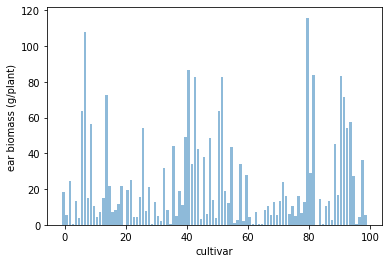

In [278]:
width=0.8
x = np.arange(len(df_sims_cvarmean.dm_ear))
plt.bar(x-width/2, df_sims_cvarmean.dm_ear, width, alpha=0.5)
plt.xlabel('cultivar')
plt.ylabel('ear biomass (g/plant)')

Text(0, 0.5, 'ear biomass (g/plant)')

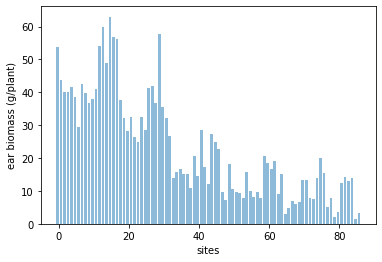

In [280]:
width=0.8
x = np.arange(len(df_sims_sitemean.dm_ear))
plt.bar(x-width/2, df_sims_sitemean.dm_ear, width, alpha=0.5)
plt.xlabel('sites')
plt.ylabel('ear biomass (g/plant)')

### Notes
Current model and/or cultivar setup clearly favors Southern locations <br/> 
Likely due to simulations in those locations reaching full maturity

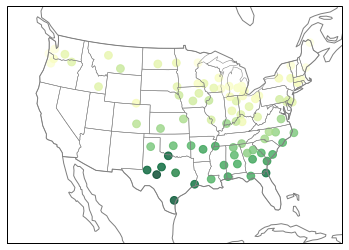

In [216]:
from palettable.colorbrewer.sequential import YlGn_9
sites = df_sites_info[df_sites_info.site.isin(df_sims_sitemean.index)]

fig = plt.figure(figsize=(6,5))
ax1 = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
                          central_latitude=39.5, central_longitude=-98.35))
ax1.set_extent([-123, -72, 19, 53])
ax1.scatter(sites.lon, sites.lat, transform=ccrs.PlateCarree(), 
            s=60, c=df_sims_sitemean.dm_ear, cmap=YlGn_9.mpl_colormap, alpha=0.8)
ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)

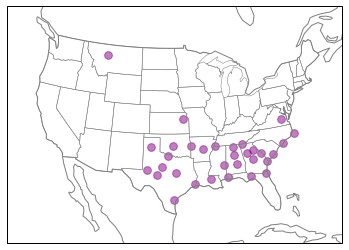

In [299]:
test_sites = set(df_sims[df_sims.note == '"Matured"'].site)
test_sites_loc = df_sites_info[df_sites_info.site.isin(test_sites)]

fig = plt.figure(figsize=(6,5))
ax1 = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
                          central_latitude=39.5, central_longitude=-98.35))
ax1.set_extent([-123, -72, 19, 53])
ax1.scatter(test_sites_loc.lon, test_sites_loc.lat, transform=ccrs.PlateCarree(), 
            s=60, c='purple', alpha=0.5)
ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)

In [339]:
df_sites_info

,site,class,station,state,tzone,lat,lon,years
0,722010,1,KEY WEST INTL ARPT,FL,-5,24.550,-81.750,25
1,722020,1,MIAMI INTL AP,FL,-5,25.817,-80.300,29
2,722030,1,WEST PALM BEACH INTL ARPT,FL,-5,26.683,-80.100,19
3,722050,1,ORLANDO INTL ARPT,FL,-5,28.433,-81.333,19
4,722056,1,DAYTONA BEACH INTL AP,FL,-5,29.183,-81.067,19
...,...,...,...,...,...,...,...,...
208,727910,1,ASTORIA REGIONAL AIRPORT,OR,-8,46.150,-123.883,20
209,727920,1,OLYMPIA AIRPORT,WA,-8,46.967,-122.900,21
210,727930,1,SEATTLE SEATTLE-TACOMA INTL A,WA,-8,47.467,-122.317,24
211,727970,1,QUILLAYUTE STATE AIRPORT,WA,-8,47.933,-124.567,17


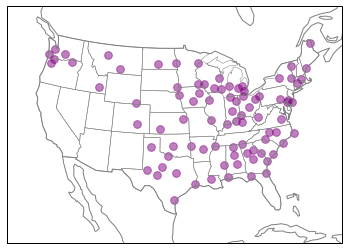

In [334]:
test_sites = set(df_sims[df_sims.note == '"grainFill"'].site)
test_sites_loc = df_sites_info[df_sites_info.site.isin(test_sites)]

fig = plt.figure(figsize=(6,5))
ax1 = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
                          central_latitude=39.5, central_longitude=-98.35))
ax1.set_extent([-123, -72, 19, 53])
ax1.scatter(test_sites_loc.lon, test_sites_loc.lat, transform=ccrs.PlateCarree(), 
            s=60, c='purple', alpha=0.5)
ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)

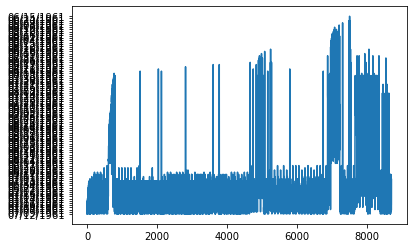

In [337]:
plt.plot(df_sims.date)

### Full visualization of sim outputs from year 1961

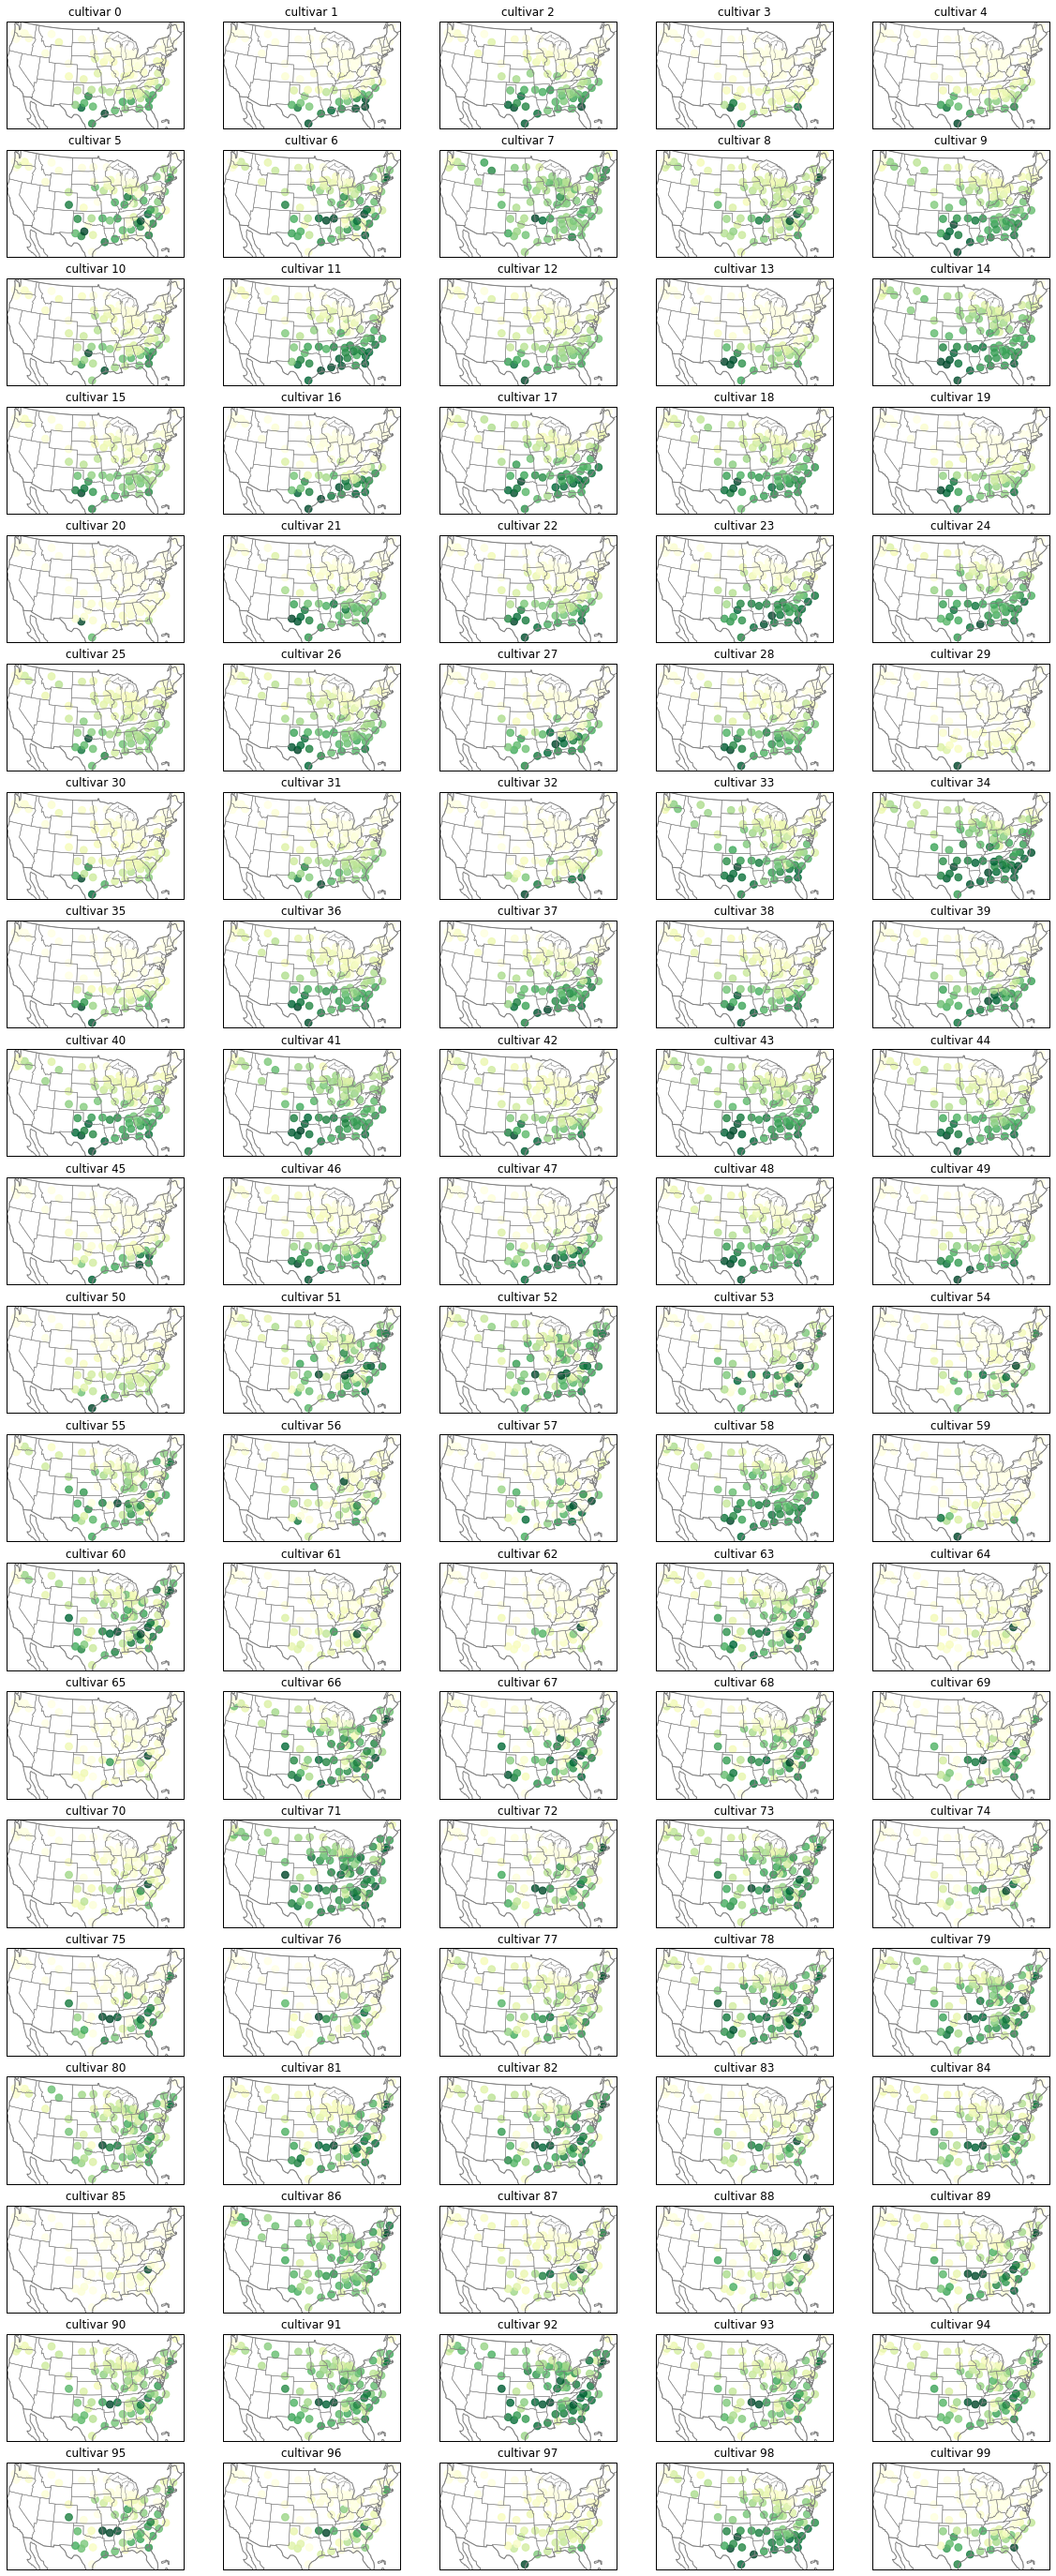

In [300]:
from palettable.colorbrewer.sequential import YlGn_9

cvars = np.arange(0,100)
extent = [-123, -72, 19, 53]
sites = df_sites_info[df_sites_info.site.isin(df_sims_sitemean.index)]

fig, axs = plt.subplots(20, 5, figsize=(20,50), 
                        subplot_kw={'projection': ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35)})

for ax, cvar in zip(axs.flatten(), cvars):
    df_sub = df_sims[df_sims.cvar == cvar]
    ax.scatter(sites.lon, sites.lat, transform=ccrs.PlateCarree(), 
               s=60, c=df_sub.dm_ear, cmap=YlGn_9.mpl_colormap, alpha=0.8)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set(title='cultivar ' + str(cvar))

In [301]:
df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv')
df_params.head()

,juv_leaves,stayGreen,rmax_ltir,phyllo,LM_min,Vcmax,Vpmax,g1,ref_potential,rmax_ltar
0,23,4.44,1.24,3.31,98.77,77.29,92.57,9.86,-3.38,0.62
1,16,7.13,0.55,3.98,89.85,67.10,87.81,1.37,-2.83,0.28
2,21,6.51,1.00,3.04,81.24,66.65,81.56,3.88,-2.63,0.50
3,24,4.67,0.68,3.24,97.70,69.56,69.67,4.86,-3.63,0.34
4,20,4.32,0.82,3.13,115.08,64.44,101.27,6.31,-3.40,0.41


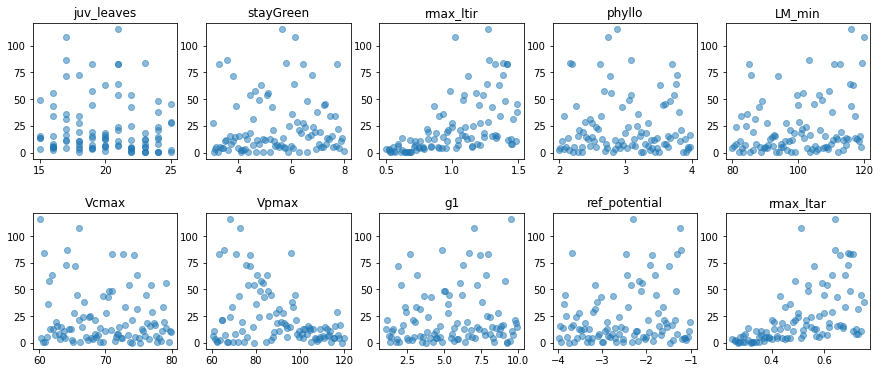

In [323]:
fig = plt.figure(figsize=(15,6))

for i in np.arange(1,11): 
    ax = fig.add_subplot(2,5,i)
    ax.scatter(df_params.iloc[:,i-1], df_sims_cvarmean.dm_ear, alpha=0.5)
    ax.set(title=df_params.columns[i-1])
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)


In [348]:
param_range = {'juv_leaves': [15, 25],
               'stayGreen': [3,8],
               'rmax_ltir': [0.5, 1.5],
               'phyllo': [2, 4],
               'LM_min': [80, 120],
               'Vcmax': [60, 80],
               'Vpmax': [60, 120],
               'g1': [1, 10], 
               'ref_potential': [-4, -1]}

In [389]:
params = df_params.columns[:-1]
df_params_fold = pd.DataFrame(columns=params)
for i in params: 
    df_params_fold[i] = fold(df_params[i], param_range[i][0], param_range[i][1])
df_params_trans = pd.DataFrame(df_params_fold.transpose())

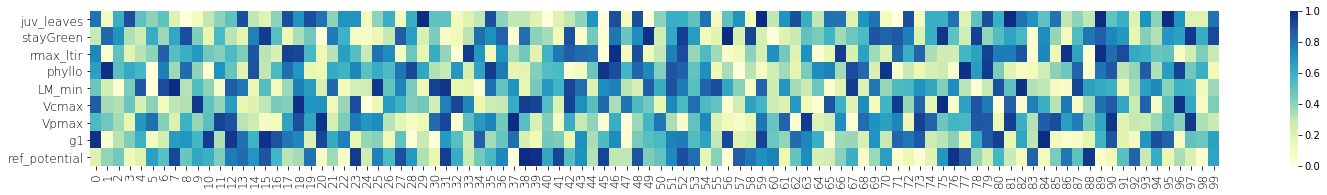

In [402]:
from palettable.colorbrewer.sequential import YlGnBu_8

fig, ax = plt.subplots(figsize=(28,5))
ax = sns.heatmap(test, cmap=YlGnBu_8.mpl_colormap)

plt.xticks(fontweight='light', fontsize=12)
plt.yticks(rotation=0, fontweight='light', fontsize=12)

# adjusting color bar specifics
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)

fig.subplots_adjust(left=0.2, bottom=0.45)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/params_100.png', format='png', dpi=800, transparent=True)

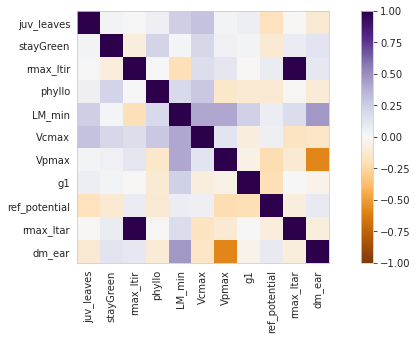

In [331]:
params = test.columns

with sns.axes_style('whitegrid'): # adding this line just makes the figure look a bit nicer
    
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(output, cmap='PuOr', vmin=-1, vmax=1)
    ax.set_xticks(np.arange(0,11))
    ax.set_xticklabels(params, rotation=90)
    ax.set_yticks(np.arange(0,11))
    ax.set_yticklabels(params, rotation=0)

    ax.grid(False)
    plt.colorbar(im)
    fig.subplots_adjust(left=-0.5, bottom=0.25, right=0.95, top=0.95)

    
    # 200429 - can further add * to indicate statistical significance
    #          when you have that info
    # 200429 - now that I'm thinking more, this figure is probably overkill
    #          since I don't really need all the correlatoins between all parameters
    #          maybe can modifiy this later to show correlation with different model output
    #          such as ear, total biomass, season length, etc. 
    # 200818 - will likely need to standardize the parameter values for this fig to have any meaning

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/pcc.png', dpi=800)

#### *Note when converting from dm_ear to yield:
1. Planting density 
2. Shelling percentage (grain weight/ear weight)
    - scaler that converts ear mass to actual grain yield
    - 0.86 is the scale value used in previous paper but need to find citation to back it
    - Looking around seems like 0.8 is a common value people use when corn is harvested at ~20-25% grain moisture
    - Haven't really found a good citation yet, but here are a few links to start with: 
        - Tandzi and Mutengwa, 2020, Agronomy
        - Masuka et al., 2017, Crop Science (80% shelling percentage and 12.5% grain moisture)
        - Horrocks and Zuber, 1970